# Simulation analysis

This notebook is a minimal example of a simulated perturbation in [CellOracle](https://github.com/morris-lab/CellOracle). Compared to the official docs, there is little new material; rather, we strip down the docs to make them easier to grasp. 

Read more about CellOracle [here](https://www.biorxiv.org/content/10.1101/2020.02.17.947416v3)

In [4]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import celloracle as co
import warnings
warnings.filterwarnings(action='once')

co.check_python_requirements()
co.test_R_libraries_installation()
    
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300
save_folder = "figures"
os.makedirs(save_folder, exist_ok=True)

/home/ekernf01/.local/share/r-miniconda/envs/cscb/lib/python3.9/site-packages/celloracle/trajectory/markov_simulation.py:17: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_walk" failed type inference due to: Undecided type $22load_method.7 := <undecided>
During: resolving caller type: $22load_method.7
During: typing of call at /home/ekernf01/.local/share/r-miniconda/envs/cscb/lib/python3.9/site-packages/celloracle/trajectory/markov_simulation.py (40)


File "../../../../../.local/share/r-miniconda/envs/cscb/lib/python3.9/site-packages/celloracle/trajectory/markov_simulation.py", line 40:
def _walk(start_cell_id_array, transition_prob, n_steps):
    <source elided>

    li.append(list(ids_now))
    ^

  @jit(i8[:,:](i8[:], f8[:,:], i8))
/home/ekernf01/.local/share/r-miniconda/envs/cscb/lib/python3.9/site-packages/celloracle/trajectory/markov_simulation.py:17: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplift

R path: /usr/bin/R
Build process aborts.
checking_installation: igraph -> NG
 R library, igraph is unavailable. Please check installation.
Build process aborts.
checking_installation: linkcomm -> NG
 R library, linkcomm is unavailable. Please check installation.
Build process aborts.
checking_installation: rnetcarto -> NG
 R library, rnetcarto is unavailable. Please check installation.


/home/ekernf01/.local/share/r-miniconda/envs/cscb/lib/python3.9/site-packages/celloracle/network_analysis/use_r_scripts.py:75: ResourceWarning: unclosed file <_io.BufferedReader name=44>
  print(f" R library, {i} is unavailable. Please check installation.")
/home/ekernf01/.local/share/r-miniconda/envs/cscb/lib/python3.9/site-packages/ipykernel/pylab/config.py:79: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


We use the example dataset from [Paul et al 2015](https://www.cell.com/cell/pdfExtended/S0092-8674(15)01493-2) and a pre-built default base network derived from motif analysis of ATAC data.

In [5]:
adata = co.data.load_Paul2015_data()
adata.obs["fake_cluster"] = "all_one_cluster"
base_GRN = co.data.load_mouse_scATAC_atlas_base_GRN()
base_GRN.head()

/home/ekernf01/.local/share/r-miniconda/envs/cscb/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/home/ekernf01/.local/share/r-miniconda/envs/cscb/lib/python3.9/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/X' was written without encoding metadata.
  d[k] = read_elem(f[k])
/home/ekernf01/.local/share/r-miniconda/envs/cscb/lib/python3.9/site-packages/anndata/_io/h5ad.py:238: OldFormatWarning: Element '/layers' was written without encoding metadata.
  d[k] = read_elem(f[k])
/home/ekernf01/.local/share/r-miniconda/envs/cscb/lib/python3.9/site-packages/anndata/_io/specs/methods.py:92: OldFormatWarning: Element '/layers/raw_count' was written without encoding metadata.
  return {

,peak_id,gene_short_name,9430076c15rik,Ac002126.6,Ac012531.1,Ac226150.2,Afp,Ahr,Ahrr,Aire,...,Znf784,Znf8,Znf816,Znf85,Zscan10,Zscan16,Zscan22,Zscan26,Zscan31,Zscan4
0,chr10_100050979_100052296,4930430F08Rik,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,chr10_101006922_101007748,SNORA17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,chr10_101144061_101145000,Mgat4c,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,chr10_10148873_10149183,9130014G24Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,chr10_10149425_10149815,9130014G24Rik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


How to get the expression data and the base network into the CellOracle object. 
Undo the comments to toggle common errors on and off.

In [8]:
oracle = co.Oracle()
# adata.X = adata.raw.X
oracle.import_anndata_as_raw_count(adata=adata,
                                   cluster_column_name="fake_cluster", #bad
#                                    cluster_column_name="louvain_annot", #good
                                   embedding_name="X_draw_graph_fa")
oracle.import_TF_data(TF_info_matrix=base_GRN)
oracle.addTFinfo_dictionary({"Foxn1":['Ccl25', 'Psmb11', 'Pdlim1', 'Mfsd12', 'Mreg', 'Fam57a', 'Ppp1r16b']})

If you want to put everything in one cluster, it requires setting certain other undocumented aspects of object state.

In [9]:
adata.obs["fake_cluster"]="all_one_cluster"
adata.obs.fake_cluster = adata.obs.fake_cluster.astype("category")
adata.uns["fake_cluster_colors"] = ['#1f77b4']

/home/ekernf01/.local/share/r-miniconda/envs/cscb/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Then we can train up some models and simulate a knockout. 

In [10]:
oracle.perform_PCA()
n_comps = 50
n_cell = oracle.adata.shape[0]
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)

/home/ekernf01/.local/share/r-miniconda/envs/cscb/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Auto-selected k is :66


/home/ekernf01/.local/share/r-miniconda/envs/cscb/lib/python3.9/site-packages/celloracle/trajectory/neighbors.py:402: DeprecationWarning: Please use `csr_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csr` namespace is deprecated.
  if type(mknn) is not sparse.csr.csr_matrix:


In [13]:
warnings.filterwarnings('ignore') #Otherwise, np.int nightmare
links = oracle.get_links(cluster_name_for_GRN_unit="louvain_annot", alpha=10,
                         verbose_level=10, test_mode=False, n_jobs=-1)

/home/ekernf01/.local/share/r-miniconda/envs/cscb/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/24 [00:00<?, ?it/s]

inferring GRN for Ery_0...


  0%|          | 0/1849 [00:00<?, ?it/s]

inferring GRN for Ery_1...


  0%|          | 0/1849 [00:00<?, ?it/s]

inferring GRN for Ery_2...


  0%|          | 0/1849 [00:00<?, ?it/s]

inferring GRN for Ery_3...


  0%|          | 0/1849 [00:00<?, ?it/s]

inferring GRN for Ery_4...


  0%|          | 0/1849 [00:00<?, ?it/s]

inferring GRN for Ery_5...


  0%|          | 0/1849 [00:00<?, ?it/s]

inferring GRN for Ery_6...


  0%|          | 0/1849 [00:00<?, ?it/s]

inferring GRN for Ery_7...


  0%|          | 0/1849 [00:00<?, ?it/s]

inferring GRN for Ery_8...


  0%|          | 0/1849 [00:00<?, ?it/s]

inferring GRN for Ery_9...


  0%|          | 0/1849 [00:00<?, ?it/s]

inferring GRN for GMP_0...


  0%|          | 0/1849 [00:00<?, ?it/s]

inferring GRN for GMP_1...


  0%|          | 0/1849 [00:00<?, ?it/s]

inferring GRN for GMP_2...


  0%|          | 0/1849 [00:00<?, ?it/s]

inferring GRN for GMPl_0...


  0%|          | 0/1849 [00:00<?, ?it/s]

inferring GRN for GMPl_1...


  0%|          | 0/1849 [00:00<?, ?it/s]

inferring GRN for Gran_0...


  0%|          | 0/1849 [00:00<?, ?it/s]

inferring GRN for Gran_1...


  0%|          | 0/1849 [00:00<?, ?it/s]

inferring GRN for Gran_2...


  0%|          | 0/1849 [00:00<?, ?it/s]

inferring GRN for Gran_3...


  0%|          | 0/1849 [00:00<?, ?it/s]

inferring GRN for MEP_0...


  0%|          | 0/1849 [00:00<?, ?it/s]

inferring GRN for Mk_0...


  0%|          | 0/1849 [00:00<?, ?it/s]

inferring GRN for Mo_0...


  0%|          | 0/1849 [00:00<?, ?it/s]

inferring GRN for Mo_1...


  0%|          | 0/1849 [00:00<?, ?it/s]

inferring GRN for Mo_2...


  0%|          | 0/1849 [00:00<?, ?it/s]

In [14]:
links.links_dict["Ery_0"].head()

,source,target,coef_mean,coef_abs,p,-logp
0,Mef2c,0610007L01Rik,-0.000324,0.000324,0.741978,0.129609
1,Gata1,0610007L01Rik,0.002261,0.002261,0.149212,0.826197
2,Fli1,0610007L01Rik,0.002797,0.002797,0.057084,1.243489
3,Rara,0610007L01Rik,0.000354,0.000354,0.660728,0.179977
4,Klf6,0610007L01Rik,-0.002702,0.002702,0.125995,0.899648


In [15]:
links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)
oracle.get_cluster_specific_TFdict_from_Links(links_object=links)
oracle.fit_GRN_for_simulation(alpha=10, use_cluster_specific_TFdict=True)

fitting GRN again...
calculating GRN in Ery_0


  0%|          | 0/1999 [00:00<?, ?it/s]

genes_in_gem: 1999
models made for 491 genes
calculating GRN in Ery_1


  0%|          | 0/1999 [00:00<?, ?it/s]

genes_in_gem: 1999
models made for 510 genes
calculating GRN in Ery_2


  0%|          | 0/1999 [00:00<?, ?it/s]

genes_in_gem: 1999
models made for 548 genes
calculating GRN in Ery_3


  0%|          | 0/1999 [00:00<?, ?it/s]

genes_in_gem: 1999
models made for 552 genes
calculating GRN in Ery_4


  0%|          | 0/1999 [00:00<?, ?it/s]

genes_in_gem: 1999
models made for 573 genes
calculating GRN in Ery_5


  0%|          | 0/1999 [00:00<?, ?it/s]

genes_in_gem: 1999
models made for 579 genes
calculating GRN in Ery_6


  0%|          | 0/1999 [00:00<?, ?it/s]

genes_in_gem: 1999
models made for 604 genes
calculating GRN in Ery_7


  0%|          | 0/1999 [00:00<?, ?it/s]

genes_in_gem: 1999
models made for 538 genes
calculating GRN in Ery_8


  0%|          | 0/1999 [00:00<?, ?it/s]

genes_in_gem: 1999
models made for 566 genes
calculating GRN in Ery_9


  0%|          | 0/1999 [00:00<?, ?it/s]

genes_in_gem: 1999
models made for 594 genes
calculating GRN in GMP_0


  0%|          | 0/1999 [00:00<?, ?it/s]

genes_in_gem: 1999
models made for 458 genes
calculating GRN in GMP_1


  0%|          | 0/1999 [00:00<?, ?it/s]

genes_in_gem: 1999
models made for 509 genes
calculating GRN in GMP_2


  0%|          | 0/1999 [00:00<?, ?it/s]

genes_in_gem: 1999
models made for 483 genes
calculating GRN in GMPl_0


  0%|          | 0/1999 [00:00<?, ?it/s]

genes_in_gem: 1999
models made for 515 genes
calculating GRN in GMPl_1


  0%|          | 0/1999 [00:00<?, ?it/s]

genes_in_gem: 1999
models made for 491 genes
calculating GRN in Gran_0


  0%|          | 0/1999 [00:00<?, ?it/s]

genes_in_gem: 1999
models made for 494 genes
calculating GRN in Gran_1


  0%|          | 0/1999 [00:00<?, ?it/s]

genes_in_gem: 1999
models made for 497 genes
calculating GRN in Gran_2


  0%|          | 0/1999 [00:00<?, ?it/s]

genes_in_gem: 1999
models made for 536 genes
calculating GRN in Gran_3


  0%|          | 0/1999 [00:00<?, ?it/s]

genes_in_gem: 1999
models made for 543 genes
calculating GRN in MEP_0


  0%|          | 0/1999 [00:00<?, ?it/s]

genes_in_gem: 1999
models made for 522 genes
calculating GRN in Mk_0


  0%|          | 0/1999 [00:00<?, ?it/s]

genes_in_gem: 1999
models made for 480 genes
calculating GRN in Mo_0


  0%|          | 0/1999 [00:00<?, ?it/s]

genes_in_gem: 1999
models made for 504 genes
calculating GRN in Mo_1


  0%|          | 0/1999 [00:00<?, ?it/s]

genes_in_gem: 1999
models made for 534 genes
calculating GRN in Mo_2


  0%|          | 0/1999 [00:00<?, ?it/s]

genes_in_gem: 1999
models made for 512 genes


In [16]:
oracle.simulate_shift(perturb_condition={"Gata1": 0.0}, n_propagation=3) 
# Fold change is stored here.
oracle.adata.layers['delta_X']

array([[ 0.00000000e+00,  3.19123961e-03,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  6.39196081e-05,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  3.55902294e-03,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -1.51553339e-04, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

This is not necessary but it's a nice visual: perturbation response displayed as a vector field. 

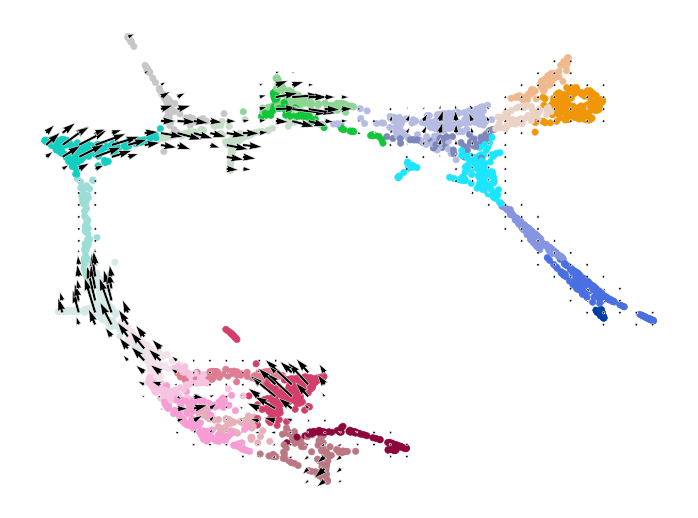

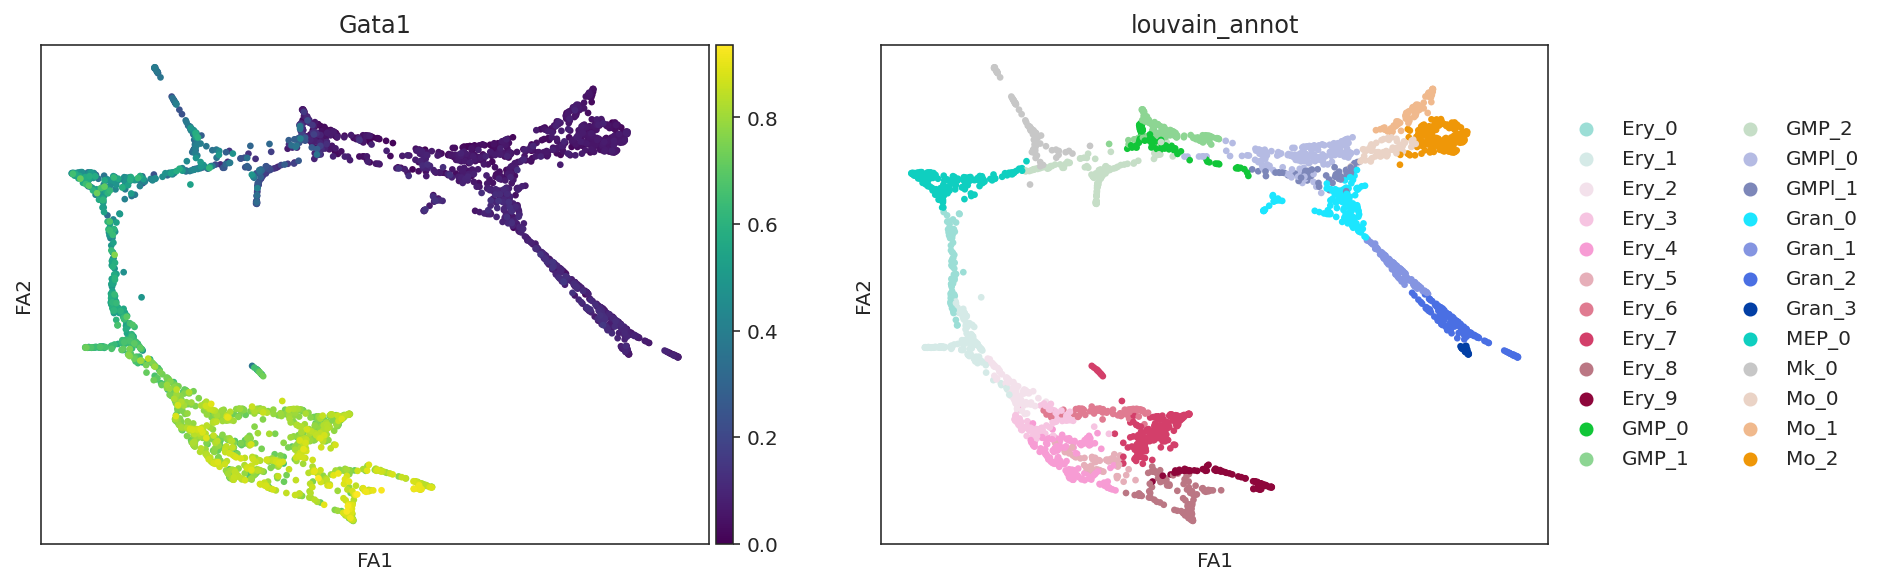

In [17]:
oracle.estimate_transition_prob(n_neighbors=200,
                                knn_random=True, 
                                sampled_fraction=1)
oracle.calculate_embedding_shift(sigma_corr=0.05)
oracle.calculate_p_mass(smooth=0.8, n_grid=40, n_neighbors=200)
oracle.calculate_mass_filter(min_mass=0.01, plot=False)
oracle.plot_cluster_whole(s=10)
oracle.plot_simulation_flow_on_grid(scale=0.5, show_background=False)
plt.show()
sc.pl.draw_graph(oracle.adata, color=["Gata1", oracle.cluster_column_name],
                 layer="imputed_count", use_raw=False, cmap="viridis")

### Troubleshooting with CellOracle

Here are many types of errors we have encountered while using CellOracle, with overly terse suggested solutions. 


> × Encountered error while trying to install package.
>
> ╰─> fa2

Install the package separately, then try the CO install again.

> ValueError: gene expression matrix (adata.X) does not seems to be raw_count because it contains negative values.

Feed it raw or normalized data, not scaled or centered.

> CellOracle takes a long time to run.

CellOracle is meant to work with 1,000-3,000 genes, not the full transcriptome. Did you select genes? Also consider downsampling to fewer cells. If you are worried about losing rare cell types, consider [geometric sketching](https://github.com/brianhie/geosketch).

> ValueError: Gene {blah} does not have enough regulatory connection in the GRNs. Cannot perform simulation.

Get a bigger base GRN or don't prune so aggressively.

> ValueError: Gene {blah} is not included in the base GRN; It is not TF or TF motif information is not available. Cannot perform simulation.

Get a bigger base GRN. 

> ValueError: {blah} is not included in the Gene expression matrix.

When you select variable genes, make sure you keep the ones you want to perturb. 


> My desired cell states are not reachable.

CellOracle is not intended for extrapolation outside the set of cell states in the training data. The training data need to include the cell state of interest. 

